# Lab 10

In [1]:
# Units of variables given in the dataset:
#    elevation: meters above sea level
#    g: mm water equivalent per meter (db/dz)
#    continentality: degrees Celsius
#    cloud cover: percentage
#    summer temperature: degrees Celsius
#    precipitation: mm per year
#    average winter precipitation: mm per month 

# NOTE: climate variables are given from climatological gridded data (CRU) provided for the whole globe on ca 50x50 km grid
#
# Variables:
#                       g: [1x136 double]  glacier mass balance gradient (as an average over the observed period)
#        median_elevation: [1x136 double]  Median glacier elevation (derived from glacier hypsometry: glacier area vs elevation)
#      summer_temperature: [1x136 double]  Summer near-surface air temperature over a grid cell (ca 50x50 km) covering the glacier (averaged over the observed period)
#           precipitation: [1x136 double]  Total annaul precipitation over a grid cell (ca 50x50 km) covering the glacier (averaged over the observed period)
#                     lat: [1x136 double]  Geographical latitude of the glacier (in degrees)
#           max_elevation: [1x136 double]  Maximum glacier elevation
#                 WGMS ID: [1x136 int64]   Given glacier ID (from World Glacier Monitoring Service)
#    winter_precipitation: [1x136 double]  Same as for precipation but derived only over winter months 
#                     lon: [1x136 double]  Geographical longitude of the glacier (in degrees)
#             cloud_cover: [1x136 double]  Annual cloud cover over a grid cell (ca 50x50 km) covering the glacier (averaged over the observed period)
#          continentality: [1x136 double]  Maximum monthly temperature minus minimum monthly temperature over a year (over a grid cell covering the glacier and averaged over the observed period). The larger the continentality index the climate is more continental (rather than maritime). 

In [2]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

In [3]:
#define RMSE as a function, since we'll use this in the NN model 
def rmse(target,prediction):
    return(np.sqrt(((target - prediction)**2).sum()/len(target)))

In [4]:
#load the data and check it out
data = pd.read_csv('glaciers.csv')
data_norm = (data - data.mean())/data.std()

In [5]:
#unpack normalized data
lat = data_norm['lat']
lon = data_norm['lon']
hmax = data_norm['max_elevation']
hmed = data_norm['median_elevation']
g = data_norm['g']
Pannual = data_norm['precipitation']
Pwinter = data_norm['winter_precipitation']
CI = data_norm['continentality']
cloud = data_norm['cloud_cover']
Tsummer = data_norm['summer_temperature']

In [6]:
#target variable: y; predictor variable(s): x
y = g
y-=np.min(g)
y/=np.max(g) #now y ranges from 0 to 1
x = data_norm.drop('g',axis=1)

In [7]:
#first do PCA, then use PCs as predictors
n_modes = np.min(np.shape(x))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(x)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

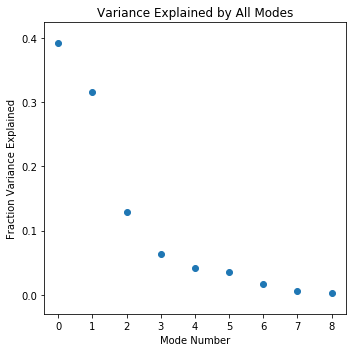

In [8]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(5,5))

plt.subplot(1,1,1)
plt.scatter(range(len(fracVar)),fracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All Modes')

plt.tight_layout()

plt.show()

### MLP:

In [9]:
#take first 5 PCs in MLP NN model
#training: first 90 points
#testing: remaining 46 points

ntrain = 110

x_train = PCs[:ntrain,:5] #train on 90 observations of first 5 PCs
y_train = y[:ntrain]

x_test = PCs[ntrain:,:5] #test on remaining observations
y_test = y[ntrain:]


In [10]:
#This chunk of code is relatively flexible and can be used to loop through a range of parameters
#We'll use this code several different times in the notebook
#Play around and see what kinds of models you can make

#First: MLP using 1 hidden layer with 10 neurons
#Second: MLP using 1 hidden layer with 1-10 neurons
#Third: something else!

max_iter = 1000 #max number of epochs to run
early_stopping = True #True = stop early if validation error begins to rise
validation_fraction = 0.1 #fraction of training data to use as validation

y_out_all_nhn = []
y_out_ensemble = []
RMSE_ensemble = [] #RMSE for each model in the ensemble
RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
nhn_best = []
nhl_best = []

##### Play around with these parameters
num_models = 10 #number of models to build for the ensemble
min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
max_nhn = 10 #maximum number of hidden neurons to loop through
max_hidden_layers = 1 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
#####

for model_num in range(num_models): #for each model in the ensemble
    
    print('Model Number: ' + str(model_num))
    
    RMSE = []
    y_out_all_nhn = []
    nhn = []
    nhl = []
    
    for num_hidden_layers in range(1,max_hidden_layers+1):
    
        print('\t # Hidden Layers = ' + str(num_hidden_layers))
    
        for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

            print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
            
            hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                                 verbose=False,
                                 max_iter=max_iter, 
                                 early_stopping = early_stopping,
                                 validation_fraction = validation_fraction)

            model.fit(x_train,y_train) #train the model

            y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
            y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE

            RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE between cumulative curves
            
            nhn.append(num_hidden_neurons)
            nhl.append(num_hidden_layers)
        
    indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
    RMSE_ensemble.append(np.min(RMSE))
    nhn_best.append(nhn[indBest])
    nhl_best.append(nhl[indBest])
    #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
    y_out_ensemble.append(y_out_all_nhn[indBest])
    
    print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
    
y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)

Model Number: 0
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 4
		 # hidden neurons = 5


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 6


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 10


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	 BEST: 1 hidden layers, 5 hidden neurons
Model Number: 1
	 # Hidden Layers = 1
		 # hidden neurons = 1


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 5


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 6


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 7


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 8


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 9
		 # hidden neurons = 10


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	 BEST: 1 hidden layers, 2 hidden neurons
Model Number: 2
	 # Hidden Layers = 1
		 # hidden neurons = 1


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 2


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 3


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 4


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 5
		 # hidden neurons = 6


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 7


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 8


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 9


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 10


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	 BEST: 1 hidden layers, 8 hidden neurons
Model Number: 3
	 # Hidden Layers = 1
		 # hidden neurons = 1


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 5


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 6


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 7


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 8
		 # hidden neurons = 9


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 10
	 BEST: 1 hidden layers, 10 hidden neurons
Model Number: 4
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 3
		 # hidden neurons = 4


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 5
		 # hidden neurons = 6


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 7


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 8
		 # hidden neurons = 9


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 10
	 BEST: 1 hidden layers, 8 hidden neurons
Model Number: 5
	 # Hidden Layers = 1
		 # hidden neurons = 1


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 2


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 3


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 4


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 5


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 6


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 10
	 BEST: 1 hidden layers, 2 hidden neurons
Model Number: 6
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 4


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 5
		 # hidden neurons = 6


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 7


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 8
		 # hidden neurons = 9


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 10


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	 BEST: 1 hidden layers, 2 hidden neurons
Model Number: 7
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 3


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 4


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 5


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 10


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	 BEST: 1 hidden layers, 7 hidden neurons
Model Number: 8
	 # Hidden Layers = 1
		 # hidden neurons = 1


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 6
		 # hidden neurons = 7


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 8


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 9
		 # hidden neurons = 10


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	 BEST: 1 hidden layers, 4 hidden neurons
Model Number: 9
	 # Hidden Layers = 1
		 # hidden neurons = 1


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 2


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 3


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 4
		 # hidden neurons = 5


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 6


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 7


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
	 BEST: 1 hidden layers, 7 hidden neurons


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


/Users/samanderson/anaconda3/envs/eosc_410/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.


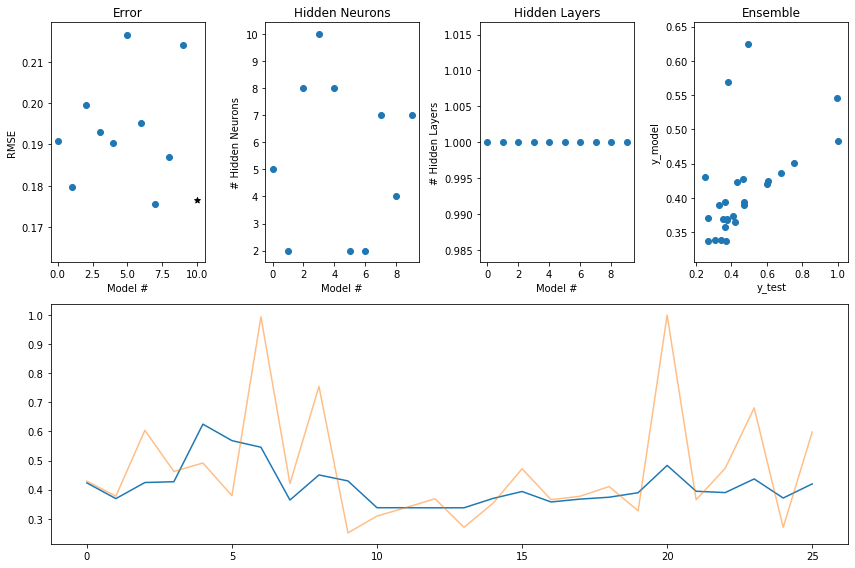

In [11]:
#visualize

plt.figure(figsize=(12,8))

plt.subplot(241)
plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
plt.xlabel('Model #')
plt.ylabel('RMSE')
plt.title('Error')

plt.subplot(242)
plt.scatter(range(len(nhn_best)),nhn_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Neurons')
plt.title('Hidden Neurons')

plt.subplot(243)
plt.scatter(range(len(nhl_best)),nhl_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Layers')
plt.title('Hidden Layers')

plt.subplot(244)
plt.scatter(y_test,y_out_ensemble_mean)
#plt.plot((np.min(y_test),np.max(y_test)),'k--')
plt.xlabel('y_test')
plt.ylabel('y_model')
plt.title('Ensemble')

plt.subplot(212)
plt.plot(y_out_ensemble_mean)
plt.plot(y_test.get_values(),alpha = 0.5)

plt.tight_layout()